In [1]:
%cd /mnt/home/zzhang/ceph/CRISPR_pred/crispr_kinn

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
from notebooks.runAmber_kinn import get_uniform_ms, get_finkelstein_ms, get_data
%matplotlib inline

0.1.1-ga


Using TensorFlow backend.


In [4]:
#wd = "outputs/bak_20220208/CNN-wtCas9_cleave_rate_log-0-ppo/"
wd = "outputs/CNN-wtCas9_cleave_rate_log-0/"
target = "wtCas9_cleave_rate_log"

res = get_data(target=target)
# unpack data tuple
x_train, y_train, x1, y1, x_test, y_test, x2, y2 = res

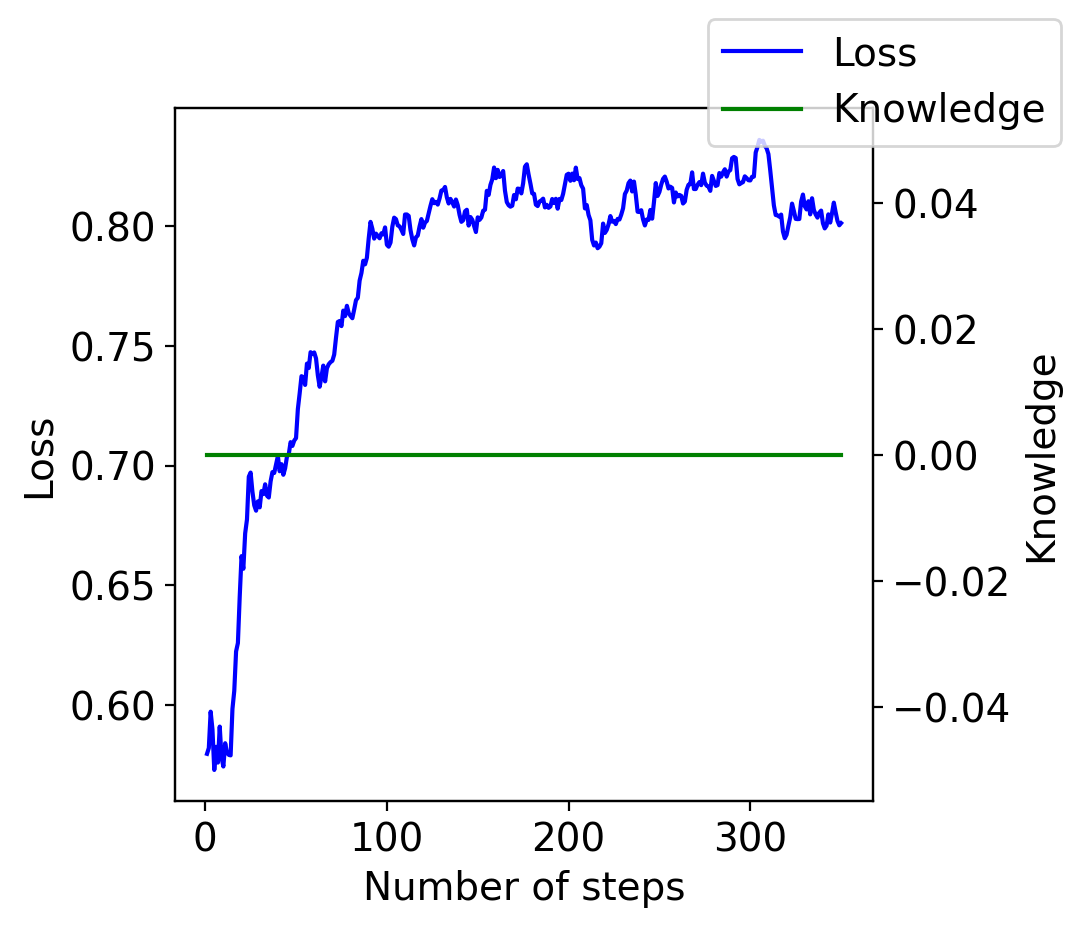

In [5]:
from IPython.display import Image

Image(filename=os.path.join(wd, "nas_training_stats.png"), width=400)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


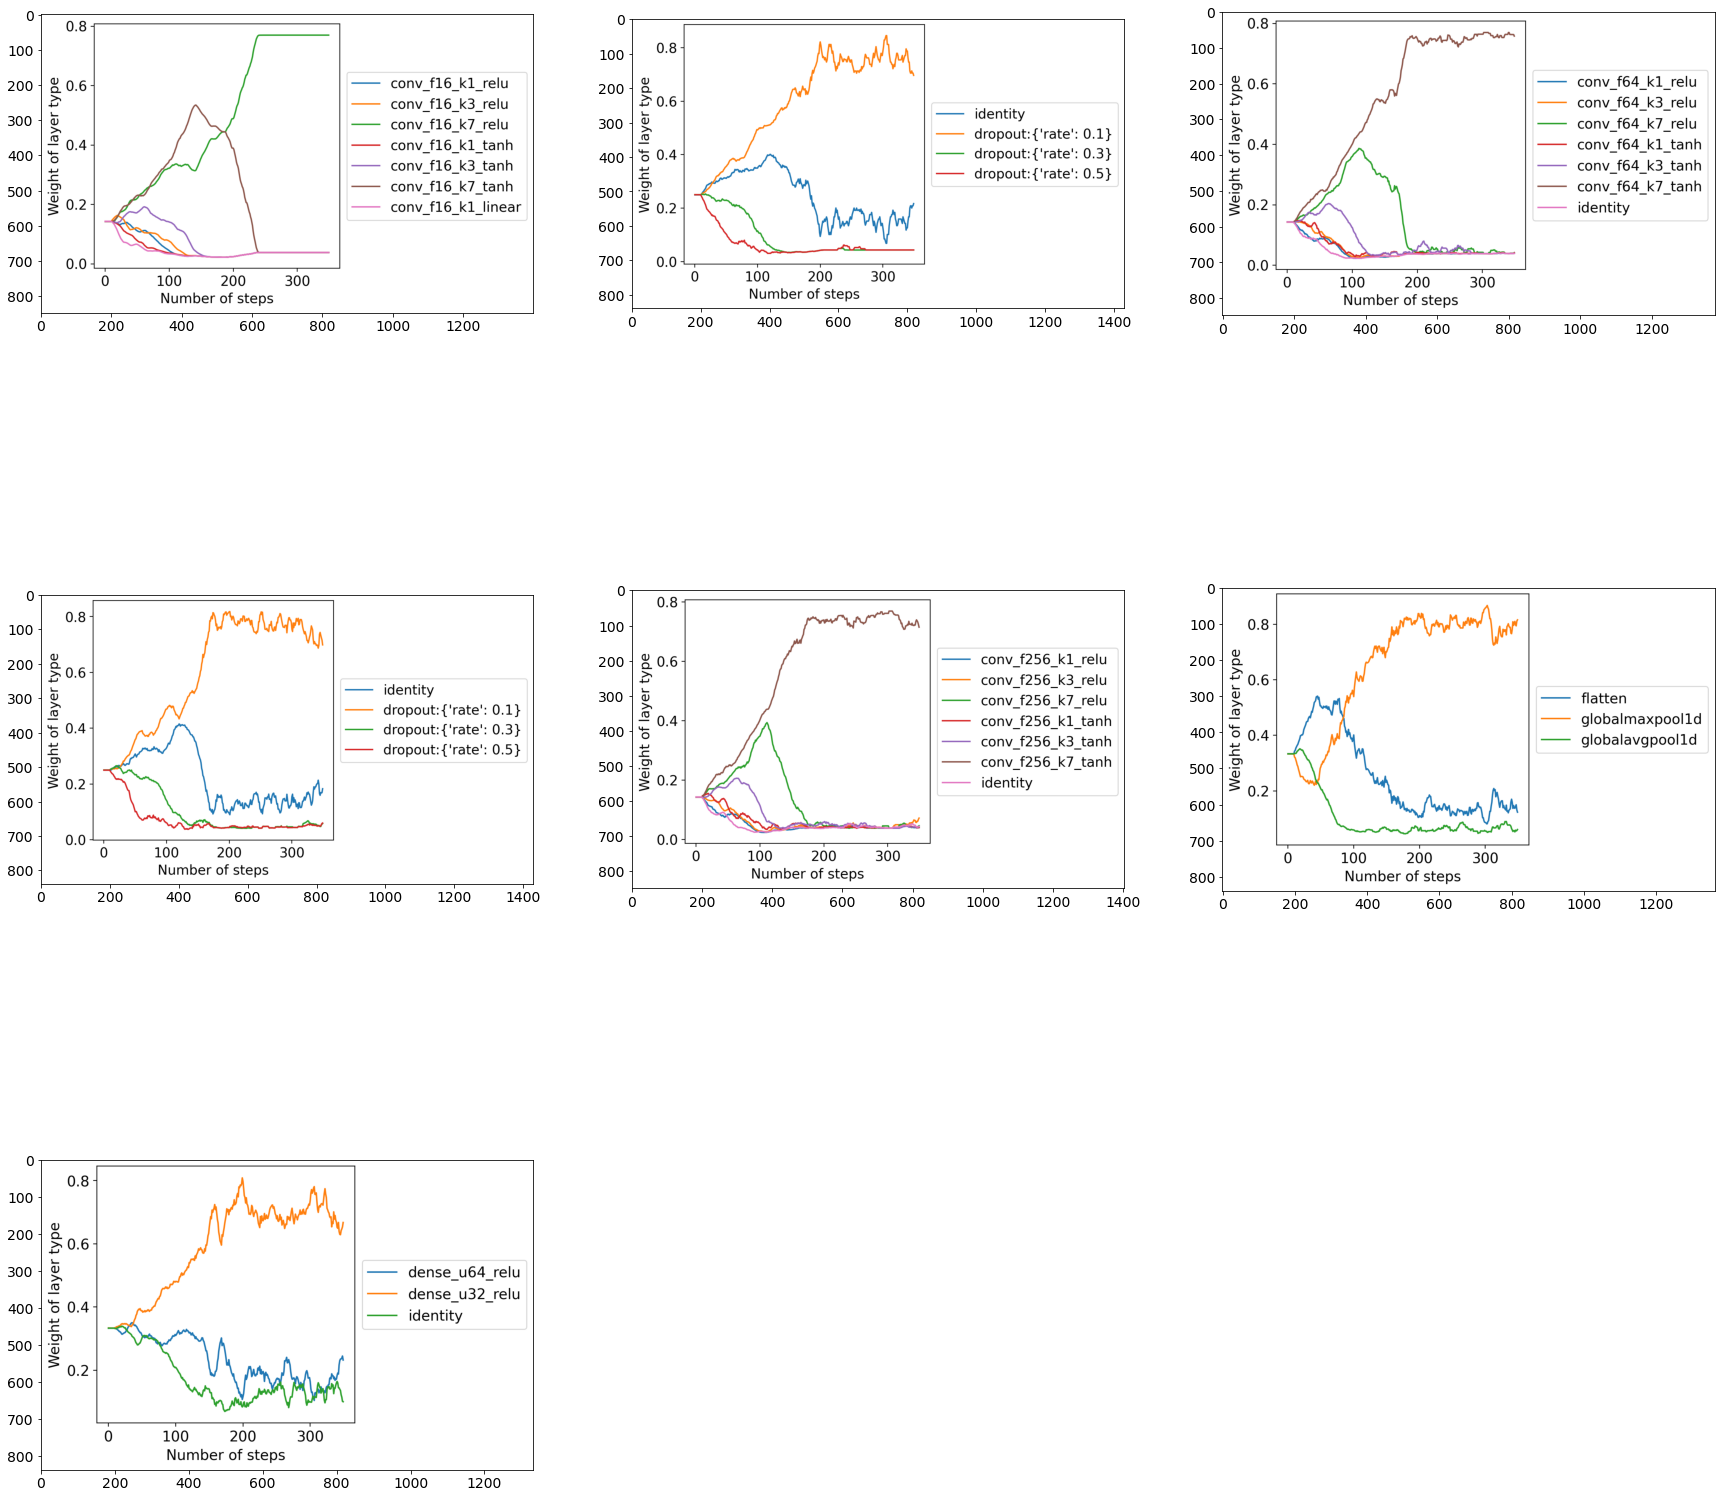

In [6]:
import matplotlib.image as mpimg

plt.figure(figsize=(30,30))
columns = 3
images = [mpimg.imread(os.path.join(wd,x)) for x in sorted([x for x in os.listdir(wd) if x.startswith("weight_at") and x.endswith("png")])]
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [7]:
train_hist = pd.read_table(os.path.join(wd, "train_history.csv"), sep=",", header=None)
train_hist.sort_values(2, ascending=False)

,0,1,2,3,4,5,6,7,8,9
2105,2105,"[0, 0.8801139534967202]",0.880114,2,1,5,1,5,2,1
3347,3347,"[0, 0.8797442190654601]",0.879744,2,2,5,1,5,2,1
1027,1027,"[0, 0.8772697111636919]",0.877270,2,2,5,1,5,2,1
2560,2560,"[0, 0.8740160581481776]",0.874016,2,1,5,1,5,2,1
2752,2752,"[0, 0.8737119335295103]",0.873712,2,1,5,1,5,2,1
...,...,...,...,...,...,...,...,...,...,...
80,80,"[0, 0.13544364002126186]",0.135444,0,2,6,3,1,1,1
1650,1650,"[0, 0.1334070547519717]",0.133407,6,3,6,0,5,1,1
15,15,"[0, 0.09665540343807495]",0.096655,6,3,6,2,0,1,2
137,137,"[0, 0.08105447689237331]",0.081054,4,2,0,0,6,1,0


In [8]:
best_trial_id = train_hist.sort_values(2, ascending=False).head(1)[0]
model = tf.keras.models.load_model(os.path.join(wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 25, 9)]           0         
_________________________________________________________________
conv0 (Conv1D)               (None, 19, 16)            1024      
_________________________________________________________________
dropout (Dropout)            (None, 19, 16)            0         
_________________________________________________________________
conv1 (Conv1D)               (None, 13, 64)            7232      
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 64)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 7, 256)            114944    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0     

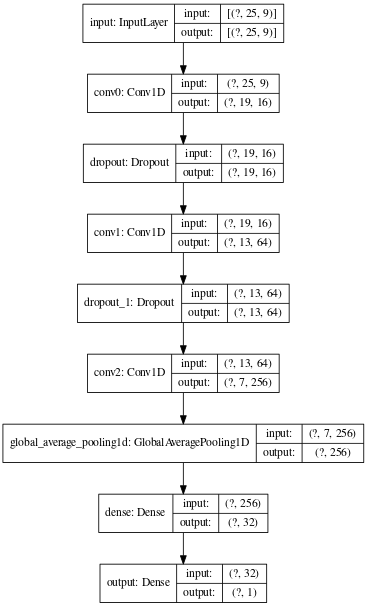

In [10]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)

In [11]:
model.compile(loss="mse", optimizer="adam")

spearman SpearmanrResult(correlation=0.7981755529987045, pvalue=0.0)
pearson (0.8806925024084656, 0.0)


Text(0.5, 0.98, 'sgRNA 2 - Validation prediction,\npcc=0.881, n=5604')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


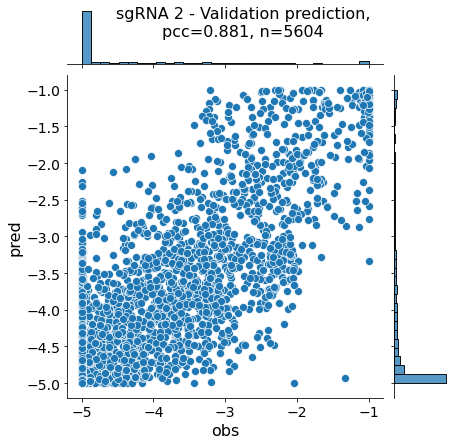

In [12]:
y_hat = model.predict(x_test).flatten()
y_hat = np.clip(y_hat, -5, -1)
h = sns.jointplot(y_test, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test))
p_old = ss.pearsonr(y_hat, y_test)
print("pearson", p_old)
h.fig.suptitle("sgRNA 2 - Validation prediction,\npcc=%.3f, n=%i"%(p_old[0],len(y_hat)), fontsize=16)

In [13]:
checkpointer = ModelCheckpoint(filepath="bestmodel.h5", mode='min', verbose=0, save_best_only=True,
                       save_weights_only=True)
earlystopper = EarlyStopping(
    monitor="val_loss",
    mode='min',
    patience=20,
    verbose=0)

hist = model.fit(x_train,
          y_train,
          batch_size=32,
          callbacks=[checkpointer, earlystopper],
          validation_data=(x_test, y_test),
          epochs=500,
          verbose=2)
model.load_weights('bestmodel.h5')

Train on 6289 samples, validate on 5604 samples
Epoch 1/500
6289/6289 - 2s - loss: 0.1643 - val_loss: 0.3371
Epoch 2/500
6289/6289 - 1s - loss: 0.1592 - val_loss: 0.3093
Epoch 3/500
6289/6289 - 1s - loss: 0.1443 - val_loss: 0.3091
Epoch 4/500
6289/6289 - 1s - loss: 0.1528 - val_loss: 0.3418
Epoch 5/500
6289/6289 - 1s - loss: 0.1479 - val_loss: 0.3329
Epoch 6/500
6289/6289 - 1s - loss: 0.1406 - val_loss: 0.3440
Epoch 7/500
6289/6289 - 1s - loss: 0.1371 - val_loss: 0.3406
Epoch 8/500
6289/6289 - 1s - loss: 0.1356 - val_loss: 0.3406
Epoch 9/500
6289/6289 - 1s - loss: 0.1352 - val_loss: 0.3387
Epoch 10/500
6289/6289 - 1s - loss: 0.1327 - val_loss: 0.3334
Epoch 11/500
6289/6289 - 1s - loss: 0.1313 - val_loss: 0.3509
Epoch 12/500
6289/6289 - 1s - loss: 0.1297 - val_loss: 0.3961
Epoch 13/500
6289/6289 - 1s - loss: 0.1295 - val_loss: 0.3170
Epoch 14/500
6289/6289 - 1s - loss: 0.1292 - val_loss: 0.3476
Epoch 15/500
6289/6289 - 1s - loss: 0.1228 - val_loss: 0.3238
Epoch 16/500
6289/6289 - 1s - l

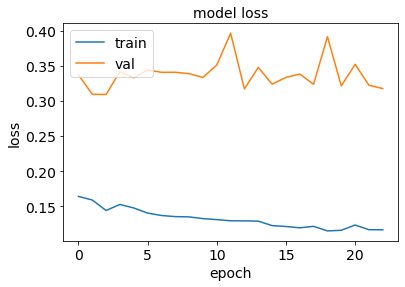

In [14]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

spearman SpearmanrResult(correlation=0.7895144482474922, pvalue=0.0)
pearson (0.876602291613554, 0.0)


Text(0.5, 0.98, 'Testing prediction, pcc=0.877')

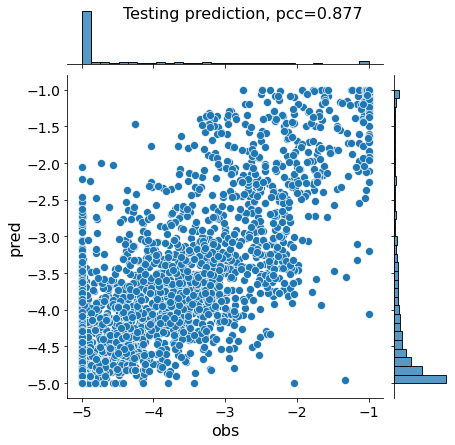

In [15]:
y_hat = model.predict(x_test).flatten()
y_hat = np.clip(y_hat, -5, -1)
h = sns.jointplot(y_test, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test))
p = ss.pearsonr(y_hat, y_test)
print("pearson", p)
h.fig.suptitle("Testing prediction, pcc=%.3f"%p[0], fontsize=16)

In [16]:
if p_old[0] >= p[0]:
    model = tf.keras.models.load_model(os.path.join(wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))
    print("retraining is overfitting; load from amber search")
else:
    print("retraining improves the model")

retraining is overfitting; load from amber search


spearman SpearmanrResult(correlation=0.8762151036082411, pvalue=0.0)
pearson (0.9633439672387603, 0.0)


Text(0.5, 0.98, 'sgRNA 1 - Train fit,\npcc=0.963, n=6289')

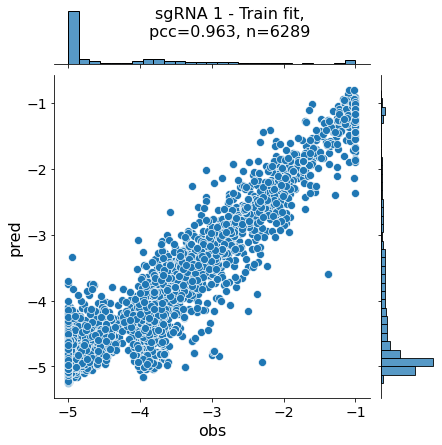

In [17]:
y_fit = model.predict(x_train).flatten()
h = sns.jointplot(y_train, y_fit)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_fit, y_train))
p = ss.pearsonr(y_fit, y_train)
print("pearson", p)
h.fig.suptitle("sgRNA 1 - Train fit,\npcc=%.3f, n=%i"%(p[0], len(y_fit)), fontsize=16)

spearman SpearmanrResult(correlation=0.7913068039314799, pvalue=3.3027116809326357e-301)
pearson (0.8788016478513396, 0.0)


Text(0.5, 0.98, 'sgRNA 2 - Test prediction,\npcc=0.879, n=1401')

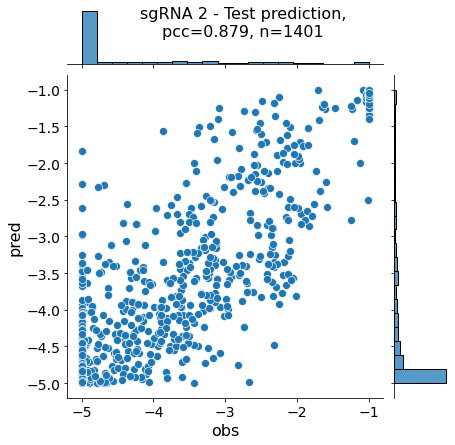

In [18]:
y_val_hat = model.predict(x2).flatten()
y_val_hat = np.clip(y_val_hat, -5, -1)

h = sns.jointplot(y2, y_val_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_val_hat, y2))
p = ss.pearsonr(y_val_hat, y2)
print("pearson", p)
h.fig.suptitle("sgRNA 2 - Test prediction,\npcc=%.3f, n=%i"%(p[0], len(y2)), fontsize=16)

spearman SpearmanrResult(correlation=0.8854113119521275, pvalue=4.1954584624989527e-234)
pearson (0.946543279431963, 0.0)


Text(0.5, 0.98, 'sgRNA 1 - Test prediction, pcc=0.947')

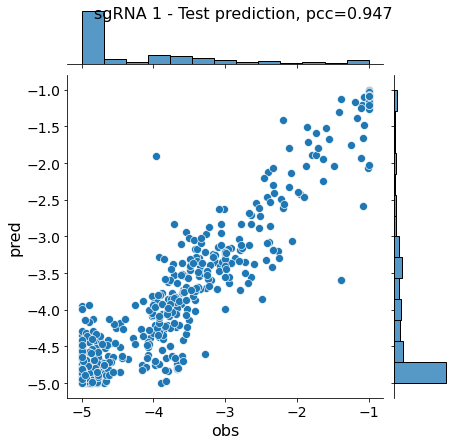

In [19]:
y_hat2 = model.predict(x1).flatten()
y_hat2 = np.clip(y_hat2, -5, -1)

h = sns.jointplot(y1, y_hat2)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat2, y1))
p = ss.pearsonr(y_hat2, y1)
print("pearson", p)
h.fig.suptitle("sgRNA 1 - Test prediction, pcc=%.3f"%p[0], fontsize=16)